# Examining Firstcal solutions for H1C IDR1

I've been worried, along with others, that the calibration solutions for IDR1 have major systematic errors. In particular I'm worried about spatial patterns in the solutions and how they change in time. This workbook will read in all the calibration solutions, average them up in time a bit to reduce the noise, and make various plots of of the calibration solutions to look for systematic patterns.

_But_, first an appology. This is one of my first python notebooks and I know it is not only hacky, but looks like it was written by an inebriated C programmer. So style appologies up front, I hope to learn but at the moment I'm sure it is cringe worthy code.

In [101]:
#import stuff
import numpy as np, scipy, matplotlib, scipy.constants
import astropy
import os, sys
import healpy
import matplotlib.pyplot as plt
import pyuvdata

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation, colors, cm
from IPython.display import HTML

In [10]:
#Change this if you want to run on your machine
wrkdir = "/Users/mmorales/Documents/Programming playground/H1C_IDR1"

### Read in archetype cal and data files

First step is to read in the first calfits file and the associated uvfits file. I'm going to use these to both check things are working and setup a bunch of arrays for later. For example, I'm going to only look at the gains for the antennas with calibrations in the first file.

In [11]:
tempCal = pyuvdata.UVCal()
tempCal.read_calfits(os.path.join(wrkdir,"zen.2458042.12552.xx.HH.uv.first.calfits"))
gain = tempCal.gain_array

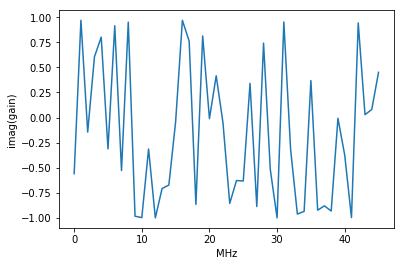

In [67]:
#plot something, to make sure it worked
plt.plot(np.imag(np.average(gain,axis=3)[:,0,512,0])) 
plt.ylabel('imag(gain)'),plt.xlabel('MHz')

plt.show()

In [13]:
#Getting a data file just so we know where the antennas are
tempData = pyuvdata.UVData()
tempData.read_uvfits(os.path.join(wrkdir, "zen.2458042.12552.HH.uv.vis.uvfits"))

### Setting up our calibration structure

What we want is a data structure where we have the complex gains in a 2D array (antenna, time). Time is straightforward, but antenna is tricky as the as the gain structure varies observation to observtation---it only lists the antennas in that calibrtion file, so not only the length but the indexing changes file by file.

There is an associated problem in getting the positions on only the antennas in the calibration file. The information is in the data file (the only reason we use it), but it has a list of all the antennas that we plan to build. Unbuilt antennas have a position that might be the center of the earth (there's a units bug so it's not clear what is going on), and there are built antennas without calibrations.

So our first step is to find the locations of the antennas in the first calibration file.


In [15]:
#read in the antenna positions from the uvdata file, correcting for ns to m bug. This is all the antennas, in
#screwey coordinates. So the task is the select out the ones we need.
allAntPos = tempData.antenna_positions*(scipy.constants.c/1e9) #Position in meters with large, not quite right offset

#initialize the new array, will be relative position in meters. 
antpos = np.zeros((len(tempCal.ant_array),2),np.double)

#so the UVData.antenna_numbers array is a 1 to 1 mapping between index and antenna number, at least for this data. 
#We'll use that to simplify
for k in range(0,len(tempCal.ant_array)):
    antNum = tempCal.ant_array[k]
    antpos[k,0] = (allAntPos[antNum,1]-allAntPos[0,1]) #make positions relative to the first antenna
    antpos[k,1] = (allAntPos[antNum,2]-allAntPos[0,2])
    
print antpos.shape

(46, 2)


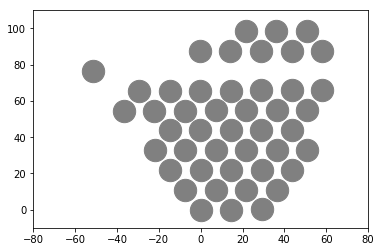

In [20]:
#A plot to see if the positions make sense, should look like array plot on the wiki
plt.scatter(antpos[:,0], antpos[:,1],s=500,c='grey')
plt.xlim([-80,80]), plt.ylim([-10,110])
#plt.axis('equal')
plt.show()

Now to read over all of the calibration files. I'm going to average the calibration solutions to 2 minutes resolution---long enough to get rid of a lot of noise, short enough to catch variations associated with sources crossing the beam.

In [26]:
#Using our first cal file, build a dictionary so we can fill in matching antenna gains from other files
antNumToIndexDic = {}
for i in range(0,len(tempCal.ant_array)):
    antNumToIndexDic.update({tempCal.ant_array[i]:i})
#setup index for time range averaging.
times = np.arange(0,60,12)

#Get a list of cal files (xx polarization)
import glob
files = glob.glob(os.path.join(wrkdir,"*xx.HH.uv.first.calfits"))

#Initialize the data array.
#we're going to average to 2 minutes, so 5 cals per file
acal = np.zeros((len(antNumToIndexDic),len(files)*5),dtype=complex) 

#Ugly to have C-like indexing, but I needed the index numbers for the cross-packing of data structures
#get each file
for i in range(0,len(files)):  #doing this as an index for packing into acal
    print os.path.basename(files[i])
    tempCal.read_calfits(files[i])
    gain = tempCal.gain_array
    
    #now iterate through the antennas in this tempCal file
    for k in range(0,len(tempCal.ant_array)):
        antNum = tempCal.ant_array[k] #get the antenna number associated with this index
        #now iterate over time ranges for each antenna
        for m in range(0,5):
            avGain = np.average(gain[k,0,512,times[m]:times[m]+11,0]) #a single complex number
            #assign to the proper location in the acal array
            #First, reverse index the antNumber of this file to that of the first file
            #Then put it at the appropriate time
            if antNum in antNumToIndexDic: acal[antNumToIndexDic[antNum],i*5+m] = avGain 
    
print "Success?"
     

zen.2458042.12552.xx.HH.uv.first.calfits
zen.2458042.13298.xx.HH.uv.first.calfits
zen.2458042.14043.xx.HH.uv.first.calfits
zen.2458042.14789.xx.HH.uv.first.calfits
zen.2458042.15535.xx.HH.uv.first.calfits
zen.2458042.16280.xx.HH.uv.first.calfits
zen.2458042.17026.xx.HH.uv.first.calfits
zen.2458042.17772.xx.HH.uv.first.calfits
zen.2458042.18517.xx.HH.uv.first.calfits
zen.2458042.19263.xx.HH.uv.first.calfits
zen.2458042.20009.xx.HH.uv.first.calfits
zen.2458042.20754.xx.HH.uv.first.calfits
zen.2458042.21500.xx.HH.uv.first.calfits
zen.2458042.22245.xx.HH.uv.first.calfits
zen.2458042.22991.xx.HH.uv.first.calfits
zen.2458042.23737.xx.HH.uv.first.calfits
zen.2458042.24482.xx.HH.uv.first.calfits
zen.2458042.25228.xx.HH.uv.first.calfits
zen.2458042.25974.xx.HH.uv.first.calfits
zen.2458042.26719.xx.HH.uv.first.calfits
zen.2458042.27465.xx.HH.uv.first.calfits
zen.2458042.28211.xx.HH.uv.first.calfits
zen.2458042.28956.xx.HH.uv.first.calfits
zen.2458042.29702.xx.HH.uv.first.calfits
zen.2458042.3044

In [29]:
#Printing out the array sizes to make sure I got all the indexing right
print acal.shape, i, m, i*5+m,  len(files), len(files)*5+5, 73*5+5

(46, 365) 72 4 364 73 370 370


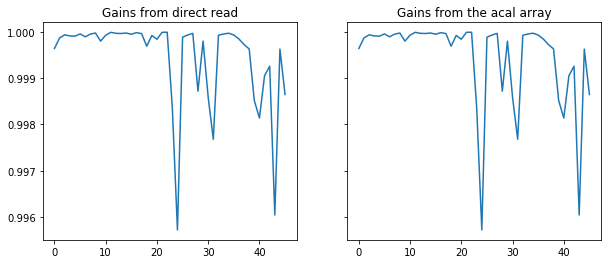

In [66]:
#Two plots to make sure the calibrations read in correctly
#Re-read in gains from the first file (tempCal variable has been used multiple times)
tempCal.read_calfits(os.path.join(wrkdir,"zen.2458042.12552.xx.HH.uv.first.calfits"))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
ax1.plot(np.abs(np.average(tempCal.gain_array[:,0,512,0:11,0],axis=1)))
ax1.set_title('Gains from direct read')

ax2.plot(np.abs(acal[:,0]))
ax2.set_title("Gains from the acal array")

plt.show()

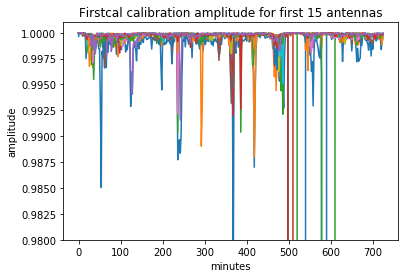

In [39]:
#Ok now let's look across time at the amplitude of the calibration
t = np.arange(0,len(acal[0,:])*2,2) #time, each cal solution is 2 minutes, assumes no gaps
for i in np.arange(0,15):
    plt.plot(t,np.abs(acal[i,:]))
plt.xlabel("minutes"), plt.ylabel("amplitude")
plt.title("Firstcal calibration amplitude for first 15 antennas")
plt.ylim([.98,1.001])
plt.show()

## Well Shit, bug \# 1

Because the firstcal gains are derived from a delay, they should be a perfect sine with amplitude 1. However, the abs() of the gain is not 1 for either time or frequency, and it is not common across antennas (a degeneracy). 

Next plot actually shows it for frequency.

In [42]:
tempCal.freq_array.shape

(1, 1024)

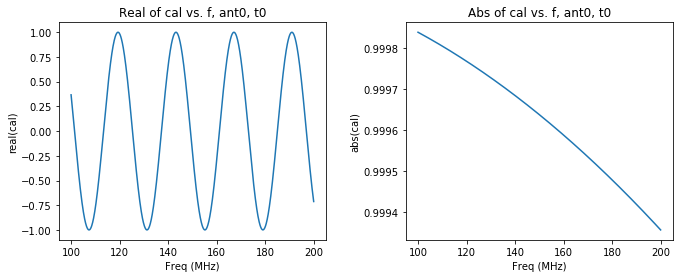

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
plt.subplots_adjust(wspace=0.3)
ax1.plot(tempCal.freq_array[0,:]/1e6, np.real(np.average(tempCal.gain_array[0,0,:,0:11,0],axis=1)))
ax1.set_ylabel("real(cal)"), ax1.set_xlabel("Freq (MHz)"), ax1.set_title("Real of cal vs. f, ant0, t0")

ax2.plot(tempCal.freq_array[0,:]/1e6, np.abs(np.average(tempCal.gain_array[0,0,:,0:11,0],axis=1)))
ax2.set_ylabel("abs(cal)"), ax2.set_xlabel("Freq (MHz)"), ax2.set_title("Abs of cal vs. f, ant0, t0")

plt.show()
#fig.tight_layout() 


So what is interesting is that the amplitude has a smooth variation vs. frequency (but not 1), but varies antenna to antenna sharply, and within one antenna also varies sharply with time.

### Moving to phase

Now let's look at the phase at 150 MHz as a function of time. While one could use the delays, I've chosen to look at the phases at a particular frequency because this makes more sense when comparing across antennas in an 'imaging' context. Affects like following a source would show up easier in phase.

But step one is to just look at the phase vs. time

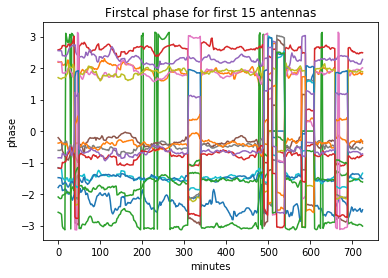

In [68]:
for i in np.arange(0,15):
    plt.plot(t,np.angle(acal[i,:]))
plt.xlabel("minutes"), plt.ylabel("phase")
plt.title("Firstcal phase for first 15 antennas")

plt.show()

One can also look at it as the change in the phase with time, to avoid issues with the branch cut in phase I'm going to use the cross product of the two complex values. For vectors of unit length (nearly true here) and for angles less than ±pi/2 this is the phase difference in radians with no branch cuts. 

In [121]:
def crossComplex(a,b):
    """Calculates the cross product of 2 complex numbers.
    Potentially useful for looking at the change in phase over the +pi/2 to -pi/2 range
    """
    cross = np.real(a)*np.imag(b)-np.imag(a)*np.real(b)
    return(cross)

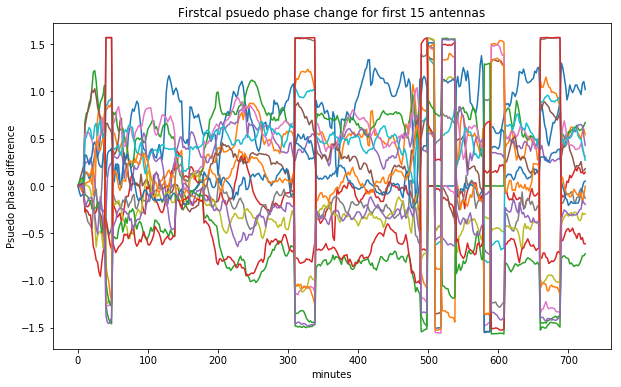

In [122]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
for i in np.arange(0,15):
    ax.plot(t,crossComplex(acal[i,:], acal[i,0])*np.pi/2)
ax.set_xlabel("minutes"), ax.set_ylabel("Psuedo phase difference")
ax.set_title("Firstcal psuedo phase change for first 15 antennas")

plt.show()

So this is very interesting in a number of ways. 

First, the dicontinuous jumps are due to real jumps in the calibration. While the cross product is bounded (for nearly unit gains) to ±pi/2 on this plot, it does not have any jumps. If the angle between the vectors becomes more than ±pi/2 then it is smoothly mapped back. Or said another way, if I smoothly increase the phase difference through multiple wraps the output here is a perfect sine wave bounded to ±pi/2. So this can make certain changes smooth, but it does not create any jumps.

I worried for a moment that this was due to missing calibrations, but if you look back at the amplitdue plot up a little higher you will see there are no periods of zero amplitude, so that's not it. Further, to get to ±pi/2 and stay there, this means the gain is _exactly_ pi/2 radians out of phase from where it started. It seems to do that frequently. Really weird.

The second 'feature' is that the phase is wandering all over the place. Note this is **not** a degeneracy, we subtracted the initial phase, and if it was a degeneracy the phase changes for all the antennas would track each other. It is also not noise. This is averaged over 2 minutes, and the structure does not look noise like due to both the long trends and the sharp jumps. 

### - The phases are not stable, but wander
### - There are weird correlated jumps to ±pi/2 from the start

Ok, now I'm going to hunt for spatially correlated changes in the phases

Let's start by just plotting the phase of the calibration solutions for each antenna for the first timestep

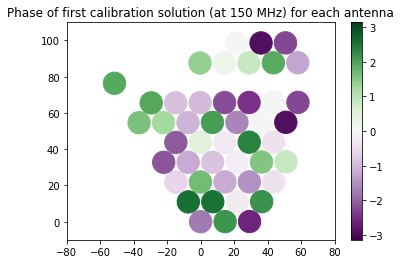

In [123]:
value = np.angle(acal[:,1])
colormap = cm.PRGn
normalize = colors.Normalize(vmin=-np.pi, vmax=np.pi)

plt.scatter(antpos[:,0], antpos[:,1],s=500, c=value, cmap=colormap, norm=normalize)
plt.xlim([-80,80]), plt.ylim([-10,110])
plt.colorbar()
plt.title('Phase of first calibration solution (at 150 MHz) for each antenna')

#plt.axis('equal')
plt.show()

Now, let's animate this to see how the phase changes with time. The next block sets up a bunch of housekeeping, and the following one actually does the animation.

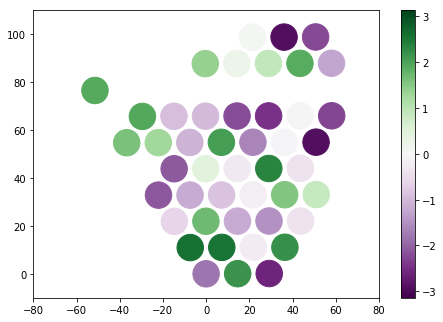

In [133]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 4))
ax0 = fig.add_axes([0, 0, 1, 1])
ax0.set_xlim([-80,80])
ax0.set_ylim([-10,110])

colormap = cm.PRGn
normalize = colors.Normalize(vmin=-np.pi, vmax=np.pi)

antDots = np.zeros(len(antpos[:,0]), dtype=[('position', float, 2),('color',float, 4)])
antDots['position'][:,0] = antpos[:,0]
antDots['position'][:,1] = antpos[:,1]
antDots['color'][:] = cm.PRGn(normalize(np.angle(acal[:,0])))

frame = ax0.scatter(antDots['position'][:,0], antDots['position'][:,1],s=700, c=antDots['color'], cmap=colormap)
m = cm.ScalarMappable(cmap=colormap, norm=normalize)
m.set_array(antDots['color'][:])
plt.colorbar(m)

plt.show()


In [136]:
# initialization function: plot the background of each frame
def update(frame_number):
    antDots['color'][:] = cm.PRGn(normalize(np.angle(acal[:,frame_number])))
    frame.set_color(antDots['color'])
    
anim = animation.FuncAnimation(fig, update, interval=200)
HTML(anim.to_html5_video())

Ok, let's look at how the phase changes using the cross product trick. Basically I'm looking at the psueduo phase line figure above, but looking for spatial patterns in what is going on.

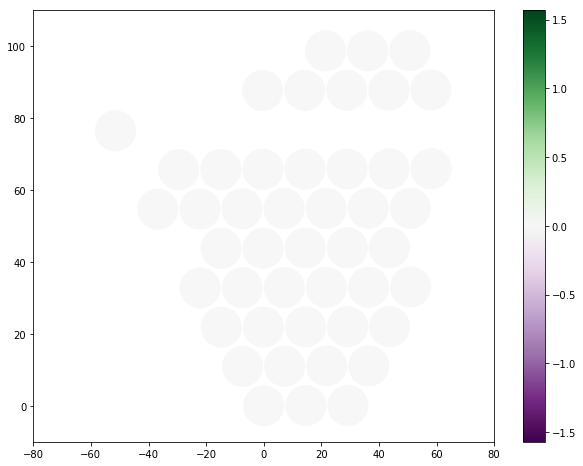

In [152]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_axes([0, 0, 1, 1])
ax0.set_xlim([-80,80])
ax0.set_ylim([-10,110])

colormap = cm.PRGn
normalize = colors.Normalize(vmin=-np.pi/2, vmax=np.pi/2)

antDots = np.zeros(len(antpos[:,0]), dtype=[('position', float, 2),('color',float, 4)])
antDots['position'][:,0] = antpos[:,0]
antDots['position'][:,1] = antpos[:,1]
antDots['color'][:] = cm.PRGn(normalize(crossComplex(acal[:,0], acal[:,0])*np.pi/2))

frame = ax0.scatter(antDots['position'][:,0], antDots['position'][:,1],s=1600, c=antDots['color'], cmap=colormap)
m = cm.ScalarMappable(cmap=colormap, norm=normalize)
m.set_array(antDots['color'][:])
plt.colorbar(m)

plt.show()

def updateDel(frame_number):
    antDots['color'][:] = cm.PRGn(normalize(crossComplex(acal[:,frame_number], acal[:,0])*np.pi/2))
    frame.set_color(antDots['color'])

In [153]:
anim = animation.FuncAnimation(fig, updateDel, interval=200, blit=False)
HTML(anim.to_html5_video())

# Discussion

Ok, so what do we see in this last movie? 

First, we can see that the changes in the phase have a strong spatial dependence. This is not noise like. 

My eye sees a 'tilt' across the array for most of the time, and the angle of this tilt (phase center) seems to move around. There are times that it seems to be quite steady, and there are times that it might walk slowly east to west,  one prominent jump and a number of smaller jumps later in the night.

I chose the reference to be the first time step, because galactic center is up and provides the strongest cross-correlations for calibration. That said, it is mostly out of the beam and a bit north. Maybe this explains why for most of the night the phase slope seems steady, but off?

### A working theory?
I think we are seeing the delay solution follow bright sources. 

The skips I think are telling. There is a major skip about a quarter of the night in (if someone knows how to plot a label on an animated figure, let me know I'd love to plot the time). Pausing at this point (4s in) shows dramatic diagonal bands. I think it picked up a source in a far sidelobe. Later skips are more subtle, but quick, and seem to separate periods of time when the phase slope is slowly changing. One theory is that it is switching from centering on one source to another as the sources move through the beam.
 
I don't understand the thought process behind the current firstcal algorithm. My interpretation of what I've heard is that it is trying to get rid of instrumental delays enough to allow omnical to be in a local minimum (no phase wraps from true solution). 

This is done by effectively demanding the phase across the array be zero. This is interesting, because it is the same prior as SELFCAL on a bright source at the center of the beam. If there is a single frequency and a source off of beam center, this assumption is not true. The dominant source will give a phase ramp across the array that is solely due to the position of the source. 

_But_, firstcal uses all of the frequencies to try and mitigate this. The assumption being that there is enough bandwidth synthesis that the phase vs. frequency will average out. I'm worried that this is the assumption that is breaking down for HERA. HERA differs from PAPER in that it is a filled array, and much more compact. This has two consequences. First, being compact there is much less opportunity for bandwidth synthesis. Second, being filled there is a weird overlap between the spacing of the telescopes (phase) and the sidelobes of the beam. This means if I put a strong source in the sidelobe of the beam, it by definition has a phase that walks by 2pi per antenna (at one frequency, when aligned with the redundant axes of the array). 

So I think we are seeing 2 effects:

- The slow wandering is due to following of bright sources in the primary beam. This is a problem that would have affected PAPER too, but because of the much higher forward gain of HERA will be much stronger (more opportunities for one source to dominate the cross-correlations). Note that since omnical cannot change the mean phase, this is a systematic effect and will lead to signal loss across time. 

- The diagonal bands at 4s in the movie are due to a bright source that appears in the antenna sidelobe and is more or less aligned with the axes of the antenna layout. In this case we get a degeneracy and we see this by alternate rows of antennas being off by nearly 2pi radians. At this time we are phasing the whole array to a source in the sidelobes, and I think this puts omnical in a local minimum. So this is a catastrophic error.

These ideas should be testable, particularly in simulation.

Regardless of the theory, I think the correlated phase changes show that firstcal is not doing what we need. I can't think of a reason that the phases of the antennas would move in such a systematic way due to solely instrumental effects.
